# Regresión LASSO

## Introducción
El algoritmo LASSO (*least absolute shrinkage and selection operator*) fue introducido por primera vez en el ámbito de la geofísica en 1986:
> Santosa, Fadil; Symes, William W. (1986). "Linear inversion of band-limited reflection seismograms". SIAM Journal on Scientific and Statistical Computing. SIAM. 7 (4): 1307–1330. [doi:10.1137/0907087](https://epubs.siam.org/doi/10.1137/0907087)

y, posteriormente, redescubierto en 1996 por Robert Tibshirani:

> Tibshirani, Robert (1996). "Regression Shrinkage and Selection via the lasso". Journal of the Royal Statistical Society. Series B (methodological). Wiley. 58 (1): 267–88. [JSTOR 2346178](https://www.jstor.org/stable/2346178).

quien le dio su nombre actual y lo popularizó.

## Descripción e identificación del tipo de algoritmo
Se trata de un **algoritmo de regresión** ya que intenta explicar una variable continua, $y$. En concreto, para cada ejemplo disponible, se intenta explicar $y$ como una combinación lineal de un conjunto de características:

$$\hat{y} = w_0 + w_1x_1 + w_2 x_2  + \ldots + w_m x_M,$$
donde:
- $\hat{y}$ denota el valor estimado de $y$ obtenido por el algoritmo.
- $w_m, m \in [0,M]$ denotan el conjunto de pesos asignados a cada característica aprendidos por el algoritmo. Se trata, por tanto, de un **modelo parámetrico** donde los parámetros son los parámetros. 
- $x_m, m \in [0,M]$, denotan cada una de las características de los datos de entrada.

Para obtener el valor óptimo de los pesos, se minimiza una función de coste que mide el error cometido con respecto a la variable $y$ original. Esto lo convierte en un **algoritmo supervisado** ya que hace uso de un valor conocido de la variable objetivo. En concreto la función de coste que se presente optimizar es la siguiente:

$$J = \sum \left[ (y-\hat{y})^2 + \alpha  \sum_{m=0}^M | w_m| \right]$$ 
donde el sumatorio de la izquierda recorre todos los datos disponibles en nuestro conjunto de entrenamiento y $\alpha$ es un **factor de regularización (o hiperparámetro del modelo)** que penaliza la complejidad del mismo para evitar el sobreajuste.

De manera más rigurosa podríamos escribir:

$$J = \sum_{n=1}^N \left[ \left(y^{(n)}- \sum_{m=0}^M w_m x_m^{(n)}\right)^2 + \alpha  \sum_{m=0}^M | w_m| \right]$$ 

## Relación con otros algoritmos vistos en la asignatura
Este algoritmo es una versión regularizada del algoritmo de regresión lineal convencional. En una regresión lineal convencional no existe el término de regularización

$$\alpha  \sum_{m=0}^M | w_m|.$$

Otro algoritmo similar es el algoritmo de regresión *ridge*. La diferencia con este es que LASSO penaliza la suma de los valores absolutos de los pesos en lugar de la suma de los valores al cuadrado de los mismos. En términos vectoriales se dice que LASSO impone una penalización a la [norma](https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm) $\ell_1$ de los pesos mientras que *ridge* impone una penalización a la norma $\ell_2$.

Como resultado de esta regularización, LASSO consigue vectores de pesos dispersos. Es decir, vectores donde ciertos elementos son anulados. Cuanto mayor es el (hiper)parámetro de regularización, más dispersa es la solución o, equivalentemente, más coeficientes son nulos. Esta propiedad puede resultar útil para realizar una selección automatizada de características. Por esta razón LASSO es considerado un algoritmo que realiza selección de características de manera embebida.

## Selección del problema a resolver
Para demostrar el funcionamiento del algoritmo nos descargamos un conjunto de datos aptos para aplicar una tarea de regresión del [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). En concreto, hemos elegido el siguiente *dataset*:
> Auto MPG: http://archive.ics.uci.edu/ml/datasets/Auto+MPG

que contiene 9 atributos que relacionan el consumo de un vehículo en millas por galón de combustible (mpg) con las características del mismo:

1. mpg: miles per gallon, continuous
2. cylinders: number of cylinders, multi-valued discrete
3. displacement: engine displacement (cubic inches), continuous
4. horsepower: engine horsepower, continuous
5. weight: vehicle weight (lbs.), continuous
6. acceleration: time to accelerate from 0 to 60 mph (sec.), continuous
7. model year: model year (modulo 100), multi-valued discrete
8. origin: origin of car (1. American, 2. European, 3. Japanese), multi-valued discrete
9. car name: string describing the make and model (unique for each instance)

En este notebook nos fijaremos como objetivo predecir el consumo de los automóviles (variable `mpg`) en función del resto de variables. 

En primer lugar, vamos a descargar los datos:

In [1]:
# Descarga de datos
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2020-01-19 00:13:14--  http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolviendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando con archive.ics.uci.edu (archive.ics.uci.edu)[128.195.10.252]:80... conectado.
PeticiÃ³n HTTP enviada, esperando respuesta... 200 OK
Longitud: 30286 (30K) [application/x-httpd-php]
Grabando a: â€œauto-mpg.data.2â€�

     0K .......... .......... .........                       100%  159K=0,2s

2020-01-19 00:13:15 (159 KB/s) - â€œauto-mpg.data.2â€� guardado [30286/30286]



In [2]:
# Visualizamos el formato de los datos
!head auto-mpg.data

18.0   8   307.0      130.0      3504.      12.0   70  1	"chevrolet chevelle malibu"
15.0   8   350.0      165.0      3693.      11.5   70  1	"buick skylark 320"
18.0   8   318.0      150.0      3436.      11.0   70  1	"plymouth satellite"
16.0   8   304.0      150.0      3433.      12.0   70  1	"amc rebel sst"
17.0   8   302.0      140.0      3449.      10.5   70  1	"ford torino"
15.0   8   429.0      198.0      4341.      10.0   70  1	"ford galaxie 500"
14.0   8   454.0      220.0      4354.       9.0   70  1	"chevrolet impala"
14.0   8   440.0      215.0      4312.       8.5   70  1	"plymouth fury iii"
14.0   8   455.0      225.0      4425.      10.0   70  1	"pontiac catalina"
15.0   8   390.0      190.0      3850.       8.5   70  1	"amc ambassador dpl"


## Preparación del entorno
Importamos las bibliotecas necesarias para el funcionamiento del código.

In [3]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

## Análisis exploratorio de los datos
Cargamos los datos, los visualizamos y hacemos un análisis exploratorio de los mismos.

In [4]:
# leemos el fichero de datos, hemos que tener en cuenta que:
# - no tiene fila de cabecera
# - tenemos que establecer unos nombres adecuados para las columnas
# - las columnas están separadas por un número variable de espacios y/o tabuladores
# - la última columna es, en realidad, un identificador del vehículo, por lo que no puede ser utilizada para predecir. La utilizaremos como índice
# - los tipos de datos de las columnas son inferidos adecuadamente. En caso contrario, deberemos especificar el tipo de datos de cada columna

column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
raw = pd.read_csv('auto-mpg.data', delim_whitespace=True, header=None, names=column_names, index_col=-1)

# podemos también fijar el tipo de la variable origin y hacerlo más interpretable asignando una cadena de texto a cada categoría
raw['origin'] = raw['origin'].astype("category")
raw['origin'].cat.categories = ["America", "Europe", "Japan"]

In [5]:
# mostramos una selección aleatoria los datos
raw.sample(n=5)

mpg  cylinders  displacement horsepower  weight  \
car_name                                                                       
renault lecar deluxe        40.9          4          85.0          ?  1835.0   
plymouth horizon            34.2          4         105.0      70.00  2200.0   
chrysler lebaron medallion  26.0          4         156.0      92.00  2585.0   
vw rabbit                   29.0          4          90.0      70.00  1937.0   
opel manta                  26.0          4          97.0      78.00  2300.0   

                            acceleration  model_year   origin  
car_name                                                       
renault lecar deluxe                17.3          80   Europe  
plymouth horizon                    13.2          79  America  
chrysler lebaron medallion          14.5          82  America  
vw rabbit                           14.2          76   Europe  
opel manta                          14.5          74   Europe

In [6]:
# tamaño y tipo de datos
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null category
dtypes: category(1), float64(4), int64(2), object(1)
memory usage: 25.4+ KB


Parece que el tipo de datos inferido por la función `read_csv` no es correcto para la variable `horsepower`. Vamos a ver qué valores contiene:

In [7]:
raw['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

Como puede verse, entre todos los valores existe un valor no convertible a número: `?`. Vamos a indicarle a la función `read_csv` que debe interpretar `?` como un valor desconocido y repetir la carga de datos.

In [8]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
raw = pd.read_csv('auto-mpg.data', 
                  delim_whitespace=True, 
                  header=None, 
                  names=column_names, 
                  index_col=-1, 
                  na_values = ['?'])

# podemos también fijar el tipo de la variable origin y hacerlo más interpretable asignando una cadena de texto a cada categoría
raw['origin'] = raw['origin'].astype("category")
raw['origin'].cat.categories = ["America", "Europe", "Japan"]

raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null category
dtypes: category(1), float64(5), int64(2)
memory usage: 25.4+ KB


Ahora parece que todos los tipos se han inferido correctamente y existen 6 valores vacíos en la columna `horsepower`. Vamos a rellenarlos con el valor medio para la columna:

In [9]:
raw['horsepower'].fillna(raw['horsepower'].mean(), inplace=True)

In [10]:
# veamos un resumen estadístico de cada columna de tipo numérico
raw.describe()

mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  398.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.199187   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   76.000000  2223.750000   
50%     23.000000    4.000000    148.500000   95.000000  2803.500000   
75%     29.000000    8.000000    262.000000  125.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model_year  
count    398.000000  398.000000  
mean      15.568090   76.010050  
std        2.757689    3.697627  
min        8.000000   70.000000  
25%       13.825000   73.000000  
50%       15.500000   76.000000  
75%       17.175000   79.000000  
max       24.800000   82.000000

In [11]:
# veamos también como se distribuyen las variables discretas
raw['cylinders'].value_counts().sort_index()
raw['model_year'].value_counts().sort_index()
raw['origin'].value_counts().sort_index()

3      4
4    204
5      3
6     84
8    103
Name: cylinders, dtype: int64

70    29
71    28
72    28
73    40
74    27
75    30
76    34
77    28
78    36
79    29
80    29
81    29
82    31
Name: model_year, dtype: int64

America    249
Europe      70
Japan       79
Name: origin, dtype: int64

Parece que todas variables discretas toman valores razonables.
Las variables `cylinders` y `model_year` son en realidad variables ordinales porque su ordenación relativa aporta información útil. Sin embargo, la variable `origin` es una variable puramente categórica: la asignación de sus valores a número es arbitraria y es necesario transformarla para que pueda ser utilizada por el algoritmo. 

Para codificarla adecuadamente, la convertimos en variables binarias que indiquen si el coche procede de cada una de las tres regiones: America, Europa o Japón. Este tipo de codificación se conoce como *one-hot encoding* (terminología utilizada principalmente en *machine learning* y `sklearn`) o codificación en *dummy variables* (terminología utilizada principalmente en estadística y en `pandas`). Para realizar esta tarea, podemos utilizar la función `pandas.get_dummies`. Antes de introducirla al algoritmo, debemos tener en cuenta que, para evitar introducir redundancia entre las columnas, debemos convertir en variables binarias todos los valores excepto 1. De momento, no descartemos ninguna de ellas, para seguir explorando los datos pero debemos recordar este punto para el futuro.

In [12]:
data = pd.get_dummies(raw, columns=['origin'], drop_first=False)

Para ayudarnos en el análisis vamos a transformar la variable objetivo en algo más directamente interpretable. Para ello, invertiremos la variable objetivo y la convertiremos en consumo de combustible.

In [13]:
data['fuel_consumption'] = 1/data['mpg']  # gallons per mile

Una manera rápida de ver las relaciones que existen entre los datos es dibujar un *scatter plot* que relacione todos los posibles pares de variables. La función `pairplot` de `seaborn` nos permite hacer esto fácilmente y además nos dibuja el histograma de cada una de las variables.

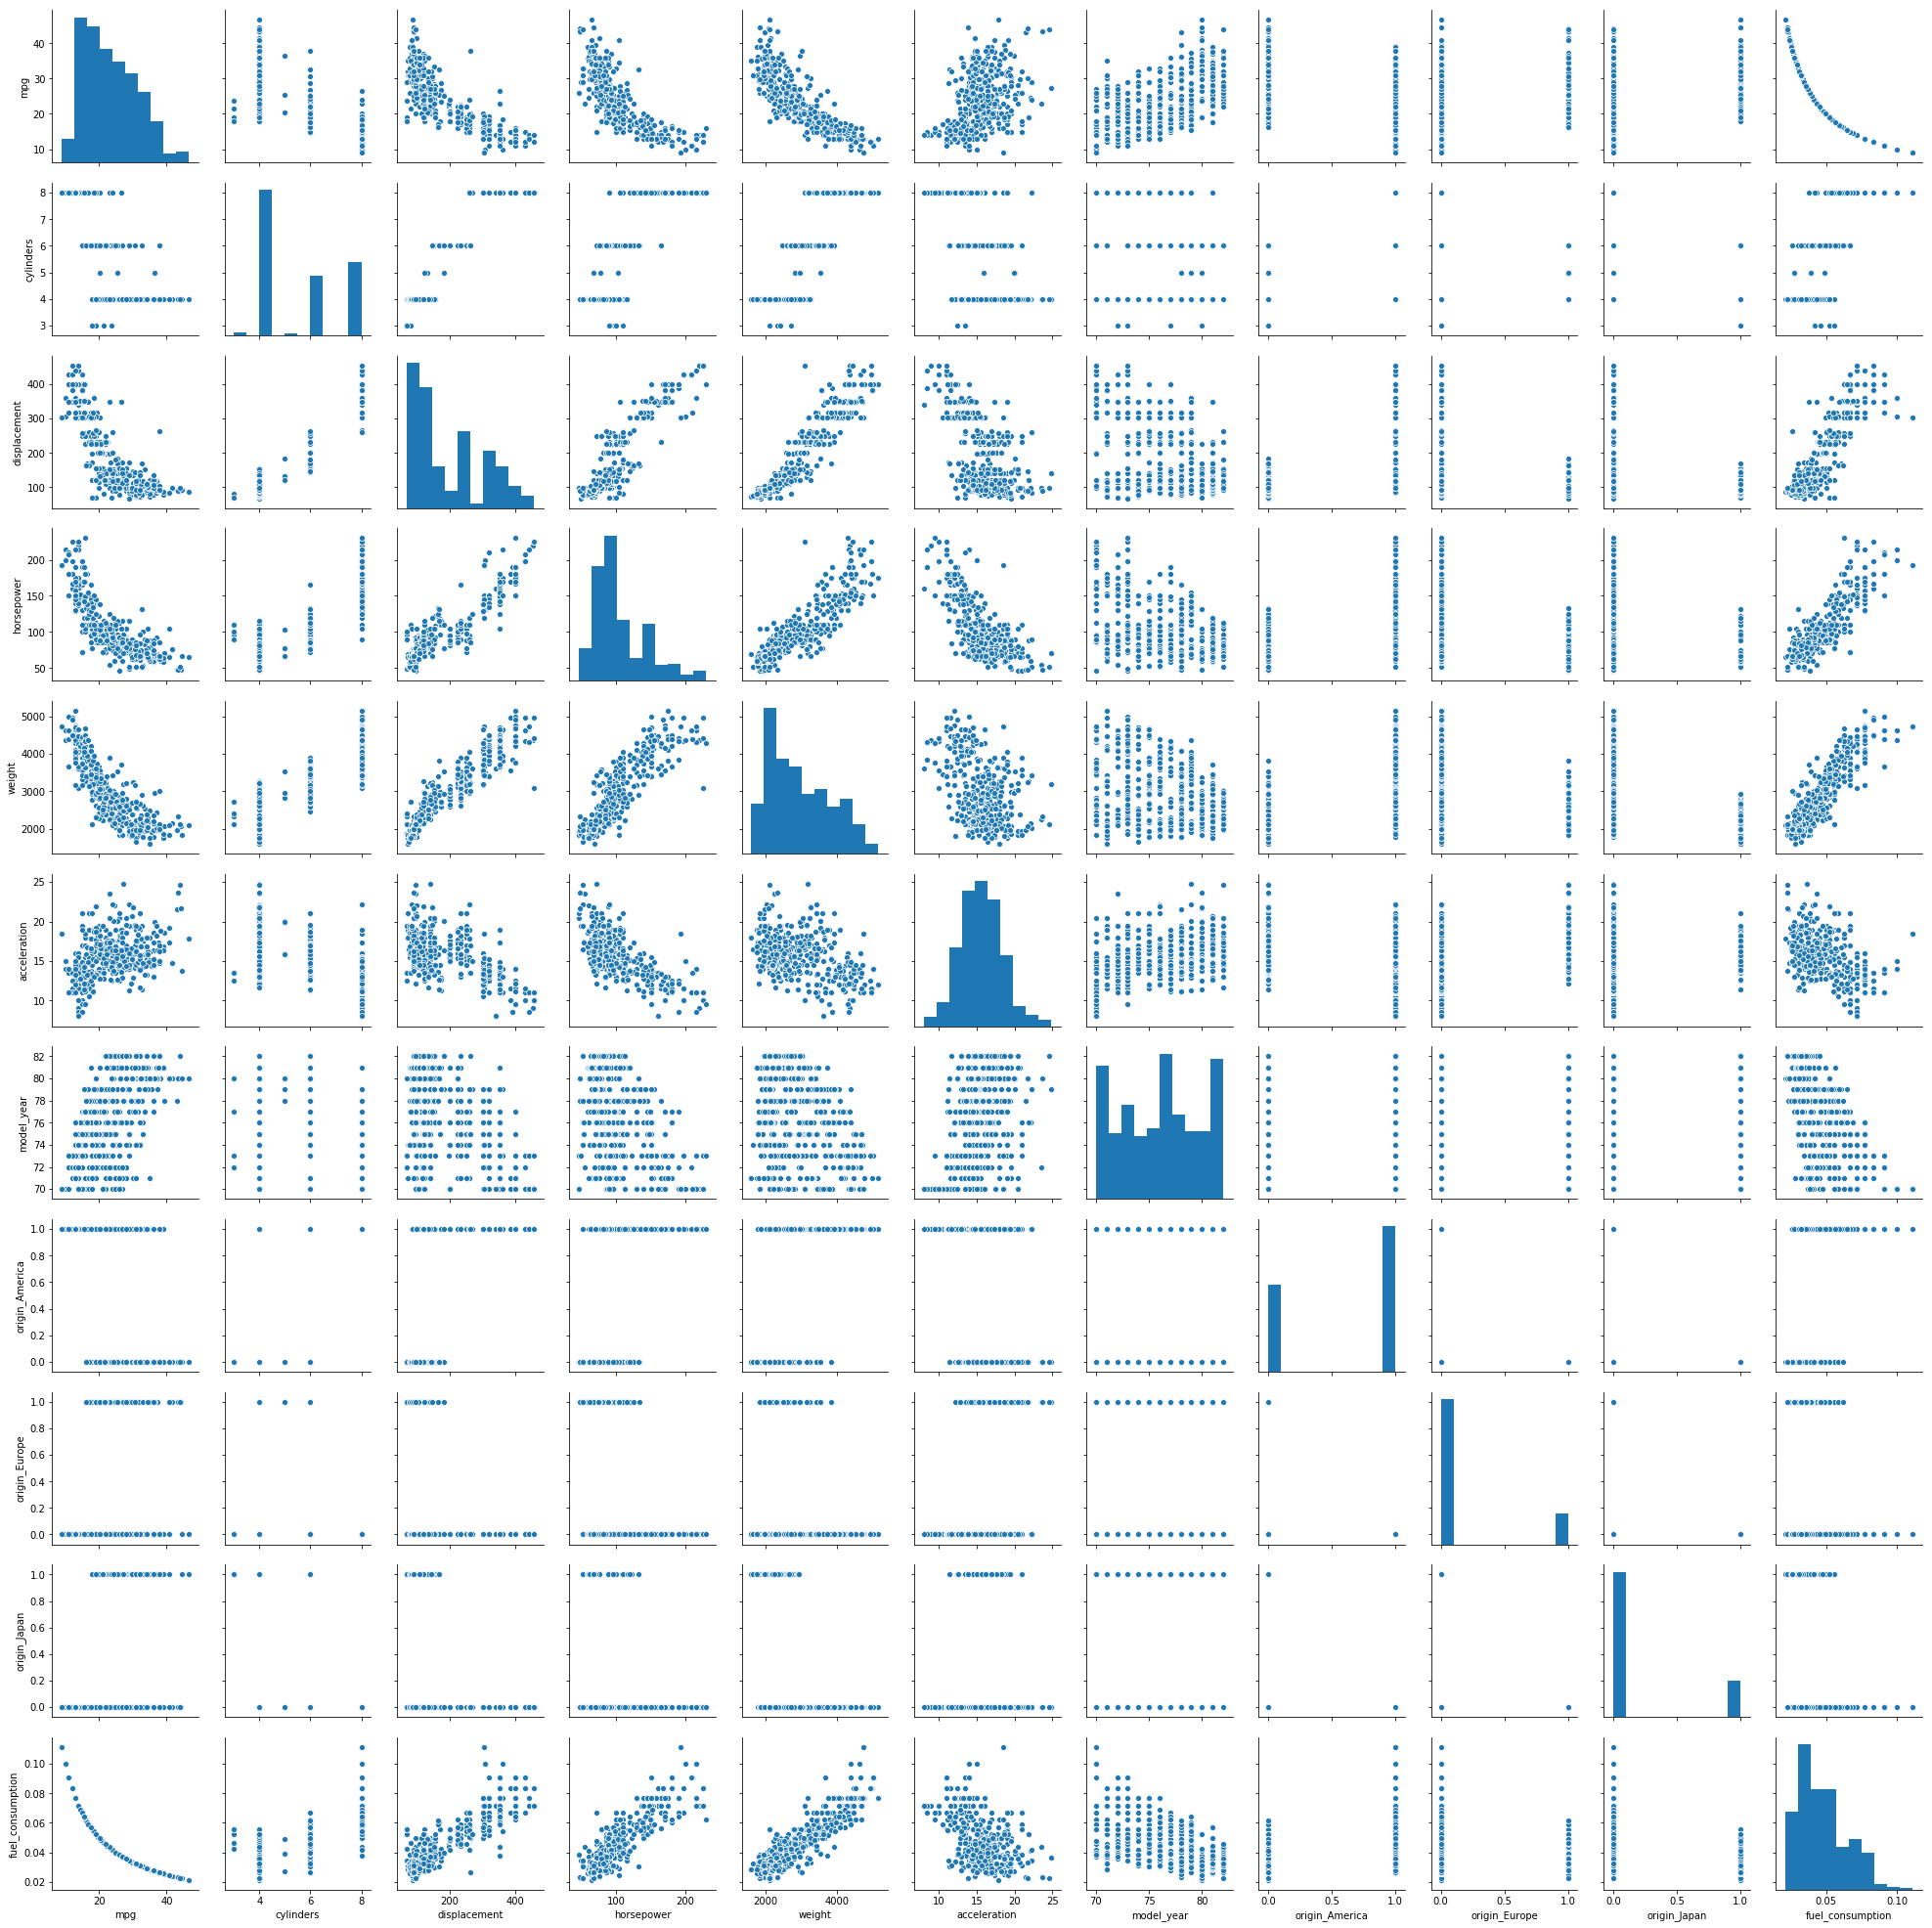

In [14]:
sns.pairplot(data);

Del estudio de estos diagramas podemos extraer varias intuiciones acerca de la relación entre variables y la relación con la variable objetivo que nos serán útiles a la hora de aplicar nuestro modelo. Además, si disponemos de conocimiento del dominio de los datos, lo podremos explicar mucho mejor:
- Las variables `displacement` (cilindrada del motor), `horsepower` (potencia del motor) y `weight` (peso del vehículo) están directamente relacionadas con el consumo (`fuel_consumption`).
- La cilindrada (`displacement`) representa el volumen agregado de todos los cilindros así que también es razonable que esté relacionada linealmente con el número de cilindros (`cylinders`).
- Los coches más antiguos (`model_year`) tienden a tener un mayor consumo.
- Algunos de los coches producidos en América tienen un consumo por encima de los producidos en Europa o Japón. Esto puede ser debido a que los coches más grandes y, por tanto, pesados (`weight`) provienen de América y el peso influye negativamente en el consumo. Además, para mantener las prestaciones, los fabricantes deben aumentar la potencia del motor (`horsepower`) y, por tanto, su cilindrada (`displacement`).
- Las relaciones con el objetivo parecen más sencillas de explicar sobre la variable `fuel_consumption` que sobre la variable `mpg`.

<!--¿Qué ocurre con la relación peso-potencia?-->

## Modelizado
Una vez concluido el análisis exploratorio de los datos vamos a aplicar un modelo para intentar predecir el consumo de los vehículos. El modelo seleccionado será el modelo LASSO. Teniendo en cuenta que se trata de un modelo lineal y que los resultados del análisis exploratorio muestran relaciones bastante lineales entre las características del vehículo y la variable `fuel_consumption`, vamos a elegir dicha variable como nuestra variable objetivo.

In [15]:
# creamos un vector con la variable objetivo
target_var = 'fuel_consumption'
y = data[target_var].values.copy()

feature_vars = ['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin_America', 'origin_Europe',
       'origin_Japan']

# creamos la matriz de features
X = data[feature_vars].values.copy()

In [16]:
# importamos el modelo que vamos a utilizar
from sklearn.linear_model import Lasso

# creamos el estimador instanciando la clase del modelo
# - para comenzar, pondremos poca regularización (alpha muy bajo)
# - permitiremos un intercepto
# - no normalizaremos las variables

alpha = 1e-6
est = Lasso(alpha=alpha, fit_intercept=True, normalize=False, random_state=42)

### Ajuste de los parámetros del modelo
A continuación vamos a mostrar como se ajustan los parámetros de este modelo.

#### Validación cruzada por el método hold-out
En primer lugar vamos a ver cómo se haría una validación cruzada con el método hold-out.

Entrenamos el modelo para obtener el **valor óptimo de los parámetros**:

In [17]:
# importamos función para dividir el conjunto de datos
from sklearn.model_selection import train_test_split
# separamos nuestros datos en conjunto de entrenamiento y conjunto de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # fijamos un estado aleatorio para garantizar la reproducibilidad de los resultados

# ajustamos el modelo a los datos de entrenamiento
est.fit(X_train, y_train)

pd.Series(est.coef_, index=feature_vars)

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

cylinders         0.001187
displacement     -0.000024
horsepower        0.000120
weight            0.000011
acceleration      0.000339
model_year       -0.001386
origin_America    0.001952
origin_Europe    -0.001375
origin_Japan      0.000000
dtype: float64

Ahora evaluamos qué tal ajusta el modelo a ambos conjuntos de datos.

In [18]:
# evaluamos el modelo en ambos conjuntos según la métrica por defecto, R2 
# (también conocida como coeficiente de determinación)
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# Nótese que esta métrica es genérica y no tiene por qué corresponder a la optimizada
# por el algoritmo en el método fit
print('Métrica R2 en entrenamiento:', est.score(X_train, y_train))
print('Métrica R2 en test:', est.score(X_test, y_test))

Métrica R2 en entrenamiento: 0.8902010648183541
Métrica R2 en test: 0.8712815713133004


Si queremos evaluar de acuerdo a otra métrica debemos hacer lo siguiente:

In [19]:
# 1. predecir
y_pred_train = est.predict(X_train)
y_pred_test = est.predict(X_test)

# 2. importar la métrica/s a evaluar
from sklearn.metrics import mean_squared_error

# 3. evaluar las métricas sobre las predicciones
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Métrica MSE en entrenamiento:', mse_train)
print('Métrica MSE en test:', mse_test)

# También podemos conseguir los resultados del método score anteriormente utilizado.
# Importamos la métrica R2
from sklearn.metrics import r2_score
# Evaluamos
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('Métrica R2 en entrenamiento:', r2_train)
print('Métrica R2 en test:', r2_test)

Métrica MSE en entrenamiento: 3.005975333361569e-05
Métrica MSE en test: 3.568433529074551e-05
Métrica R2 en entrenamiento: 0.8902010648183541
Métrica R2 en test: 0.8712815713133004


#### Validación cruzada por el método K-fold 
A la vista de las métricas anteriores es difícil decir si el algoritmo está sobreajustando o no. Observamos una pequeña diferencia entre la puntuación sobre el conjunto de entrenamiento y el de prueba, pero no sabemos cuantificar si es pequeña o grande y la variabilidad que puede llegar a tener sobre diferentes datos. Para aclarar este punto es recomendable utilizar una validación cruzada más sofisticada como K-fold.

In [20]:
# importamos el validador 
from sklearn.model_selection import cross_validate

n_folds = 4 # vamos a hacer validación cruzada K-fold en este número de folds

# evaluamos la calidad del ajuste de modelo de acuerdo a unas métricas de score
# están implementadas muchas métricas
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules
# recuerda que esta métrica no tiene por qué coincidir con la función de coste/pérdida optimizada por el algoritmo
# elegimos las mismas que anteriormente con la salvedad de que el MSE está cambiado de signo
scoring = ['neg_mean_squared_error', 'r2']
cv_results = cross_validate(est, X, y, cv=n_folds, return_train_score=True, return_estimator=True, scoring=scoring)
cv_results

{'fit_time': array([0.00250626, 0.00250745, 0.00150442, 0.00097489]),
 'score_time': array([0.0015049 , 0.00150371, 0.00050187, 0.00050092]),
 'estimator': (Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False)),
 'test_neg_mean_squared_error': array([-5.66216103e-

A partir de los resultados podemos ver que existe cierta variabilidad entre los diferentes folds: en algunos folds las puntuaciones de train y test son muy diferentes. Parece que hay algo de sobreajuste, resolveremos esto más adelante. Vamos primero a ver cómo evaluar la importancia de las variables.

### Importancia de las variables
En el modelo LASSO podemos deducir la importancia de las variables a partir de los pesos que se le asignan a cada una. Sin embargo, para que estos pesos sean comparables entre sí, todas las variables han de tener la misma varianza. Vamos a escalarlas con ayuda del objeto `StandardScaler` de `sklearn`:

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler();
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

est.fit(X_train_scaled, y_train)

print('Métrica R2 en entrenamiento:', est.score(X_train_scaled, y_train))
print('Métrica R2 en test:', est.score(X_test_scaled, y_test))

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

Métrica R2 en entrenamiento: 0.8902007885577325
Métrica R2 en test: 0.8712480486703642


Como se puede ver, los valores de $R^2$ no han cambiado a pesar de que hemos cambiado la escala de las variables, lo que significa que el algoritmo es **invariante a la escala**. Sin embargo, los coeficientes deben haber cambiado para *absorber* las diferencias de escala, y ahora nos dan una idea de la importancia relativa entre las variables.

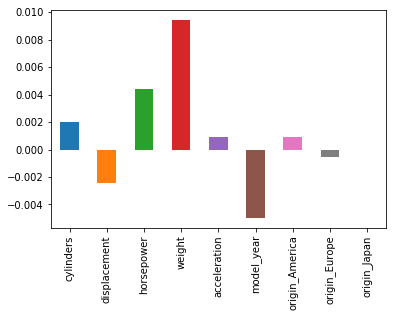

In [22]:
pd.Series(est.coef_, index=feature_vars).plot.bar();

Podemos ver como el signo y magnitud de las variables comienza a concordar con lo que habíamos visto durante el análisis exploratorio de los datos:
- Cuanto más pesa el coche, más consumo
- Cuanto más nuevo es el coche, menos consumo.
- La pequeña regularización que tenemos activa ha descubierto que una de las 3 *dummy variables* asociadas a la geografía del fabricante es redundante y la ha anulado. Además, América es mejor indicador de alto consumo que Europa.

Sin embargo, la cilindrada del motor parece indicar lo contrario de lo que esperábamos. Podría ser por la alta colinealidad que parecía existir entre las variables. Vamos a intentar encontrar un modelo más sencillo ajustando el parámetro de regularización.


### Ajuste de hiperparámetros: parámetro de regularización
Vamos a proceder a encontrar un buen valor para el parámetro de regularización que, en este caso, es nuestro único hiperparámetro. El ajuste del mismo lo haremos mediante validación cruzada.

Para poder interpretar los coeficientes debidamente debemos construir un estimador que incluya el paso de escalado. `sklearn` nos proporciona una clase `Pipeline` para construir "meta-estimadores" basados en varios pasos. Así que construiremos un `pipeline` que constará de los siguientes dos pasos:
- `scaler`: escalado
- `lasso`: LASSO

Este estimador puede ser pasado a la función de búsqueda de hiperparámetros mediante búsqueda exhaustiva en rejilla (`GridSearchCV`) junto con la rejilla de parámetros que queremos explorar y las métricas que queremos evaluar. Esta función nos devolverá un nuevo "meta-estimador" que podremos ajustar para lanzar la validación cruzada y la búsqueda de parámetros.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

est2 = Pipeline([('scaler', scaler), ('lasso', est)])

alpha_arr = np.logspace(-6, -2, 20)
param_grid = {'lasso__alpha': alpha_arr}

n_folds = 5

scoring = ['neg_mean_squared_error', 'r2'] # evaluar varias métricas en cada fold
scoring_refit = 'r2'  # elegir el mejor modelo de acuerdo a este criterio

est3 = GridSearchCV(est2, param_grid, scoring=scoring, cv=n_folds, refit=scoring_refit, return_train_score=True)

est3.fit(X, y)

C:\Users\e054961\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-06, 1.62378e-06, 2.63665e-06, 4.28133e-06, 6.95193e-06,
       1.12884e-05, 1.83298e-05, 2.97635e-05, 4.83293e-05, 7.84760e-05,
       1.27427e-04, 2.06914e-04, 3.35982e-04, 5.45559e-04, 8.85867e-04,
       1.43845e-03, 2.33572e-03, 3.79269e-03, 6.15848e-03, 1.00000e-02])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=0)

Una vez ejecutada la validación cruzada para todos los valores del parámetro, mostramos los valores medios (a lo largo de todos los folds) conseguidos para cada valor de `alpha`.

array([1.00000000e-06, 1.62377674e-06, 2.63665090e-06, 4.28133240e-06,
       6.95192796e-06, 1.12883789e-05, 1.83298071e-05, 2.97635144e-05,
       4.83293024e-05, 7.84759970e-05, 1.27427499e-04, 2.06913808e-04,
       3.35981829e-04, 5.45559478e-04, 8.85866790e-04, 1.43844989e-03,
       2.33572147e-03, 3.79269019e-03, 6.15848211e-03, 1.00000000e-02])

array([0.88718152, 0.88718106, 0.88717985, 0.88717651, 0.88716759,
       0.88714457, 0.88708423, 0.88692516, 0.88650549, 0.88570851,
       0.88466002, 0.88370629, 0.88225717, 0.88057895, 0.87720282,
       0.86908609, 0.84899221, 0.79637766, 0.66827377, 0.41347297])

array([ 0.71677248,  0.71680537,  0.71686097,  0.71696474,  0.7171234 ,
        0.71734734,  0.71765086,  0.71798809,  0.7181244 ,  0.71931906,
        0.72356005,  0.7269787 ,  0.72948331,  0.7247956 ,  0.70652821,
        0.65899225,  0.5325182 ,  0.19780672, -0.22469351, -0.90896844])

array([-3.98294651e-05, -3.98209669e-05, -3.98062918e-05, -3.97795174e-05,
       -3.97370363e-05, -3.96729107e-05, -3.95742832e-05, -3.94276463e-05,
       -3.92280212e-05, -3.88613817e-05, -3.82016942e-05, -3.78717418e-05,
       -3.77104847e-05, -3.79632551e-05, -3.90848608e-05, -4.21067394e-05,
       -5.09005293e-05, -7.56608520e-05, -1.23480595e-04, -2.04987621e-04])

array([-3.02116737e-05, -3.02118002e-05, -3.02121360e-05, -3.02130602e-05,
       -3.02155318e-05, -3.02219085e-05, -3.02386278e-05, -3.02827177e-05,
       -3.03990597e-05, -3.06176722e-05, -3.08923596e-05, -3.11490052e-05,
       -3.15427120e-05, -3.19871067e-05, -3.28825721e-05, -3.50503867e-05,
       -4.03815153e-05, -5.43317095e-05, -8.83567800e-05, -1.56253876e-04])

Best alpha: 0.000336


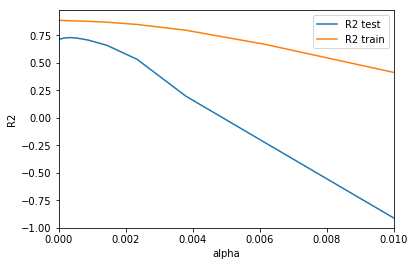

In [24]:
alpha_arr 

est3.cv_results_['mean_train_r2']
est3.cv_results_['mean_test_r2']

est3.cv_results_['mean_test_neg_mean_squared_error']
est3.cv_results_['mean_train_neg_mean_squared_error']

_ = plt.plot(alpha_arr, est3.cv_results_['mean_test_r2'], label='R2 test')
_ = plt.plot(alpha_arr, est3.cv_results_['mean_train_r2'], label='R2 train')
_ = plt.xlim([1e-8, 1e-2]);
_ = plt.xlabel('alpha')
_ = plt.ylabel('R2')
_ = plt.legend(loc='best')


best_alpha = est3.best_params_['lasso__alpha']
print('Best alpha: {:.4g}'.format(best_alpha))

Por último, procederemos a obtener los coeficientes obtenidos por el mejor estimador (será aquel correspondiente a `best_alpha`)

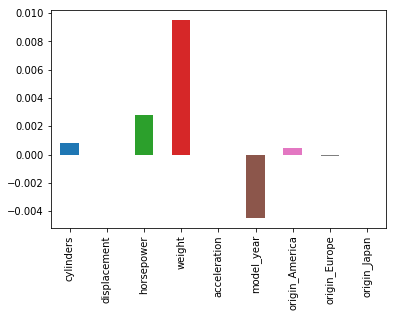

In [25]:
coefs = est3.best_estimator_.named_steps['lasso'].coef_
pd.Series(coefs, index=feature_vars).plot.bar();

A la vista de los resultados, se concluye que la regularización ha conseguido desactivar la variable asociada a la cilindrada del motor (`displacement`) y a la aceleración (`acceleration`), y apostar por darle más importancia al peso del vehículo (`weight`). Este es un comportamiento esperado, pues como vimos, estas 3 variables estaban bastante correlacionadas.  

Para este valor del parámetro, las diferencias entre el conjunto de entrenamiento y el de prueba no son sustanciales. Por tanto, podemos concluir que **no existe sobreajuste**.

## Predicción final

A continuación vamos a ajustar el modelo sobre todo el conjunto de datos. A falta de un conjunto de prueba real, vamos a mostrar los resultados sobre el mismo conjunto de entrenamiento.

LASSO no dispone de un mecanismo para evaluar la incertidumbre de la solución. Algunos clasificadores de scikit-learn disponen del método `predict_proba` para computar estimas de la probabilidad de que el resultado sea correcto, pero en este caso no existe algo similar.

In [26]:
best_est = est3.best_estimator_
best_est.fit(X, y)
y_pred = best_est.predict(X)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0003359818286283781, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=42, selection='cyclic', tol=0.0001, warm_start=False))])

In [27]:
mpg_pred = 1/y_pred
results = pd.DataFrame({'fuel_consumption': data['fuel_consumption'],
             'fuel_consumption_pred': y_pred,
              'mpg': data['mpg'],
              'mpg_pred': mpg_pred
             })
results

fuel_consumption  fuel_consumption_pred  \
car_name                                                                     
chevrolet chevelle malibu                  0.055556               0.064509   
buick skylark 320                          0.066667               0.069174   
plymouth satellite                         0.055556               0.065202   
amc rebel sst                              0.062500               0.065168   
ford torino                                0.058824               0.064620   
ford galaxie 500                           0.066667               0.078840   
chevrolet impala                           0.071429               0.080587   
plymouth fury iii                          0.071429               0.079752   
pontiac catalina                           0.071429               0.081747   
amc ambassador dpl                         0.066667               0.072753   
dodge challenger se                        0.066667               0.068081   
plymouth 'cuda 340                         0.071429               0.067869   
chevrolet monte carlo                      0.066667               0.068845   
buick estate wagon (sw)                    0.071429               0.066734   
toyota corona mark ii                      0.041667               0.046239   
plymouth duster                            0.045455               0.053439   
amc hornet                                 0.055556               0.052923   
ford maverick                              0.047619               0.049953   
datsun pl510                               0.037037               0.043017   
volkswagen 1131 deluxe sedan               0.038462               0.036439   
peugeot 504                                0.040000               0.048806   
audi 100 ls                                0.041667               0.046311   
saab 99e                                   0.040000               0.046058   
bmw 2002                                   0.038462               0.045787   
amc gremlin                                0.047619               0.051001   
ford f250                                  0.100000               0.083149   
chevy c20                                  0.100000               0.079378   
dodge d200                                 0.090909               0.080173   
hi 1200d                                   0.111111               0.082860   
datsun pl510                               0.037037               0.041802   
...                                             ...                    ...   
chevrolet cavalier wagon                   0.037037               0.035188   
chevrolet cavalier 2-door                  0.029412               0.032441   
pontiac j2000 se hatchback                 0.032258               0.034241   
dodge aries se                             0.034483               0.033608   
pontiac phoenix                            0.037037               0.036399   
ford fairmont futura                       0.041667               0.038002   
amc concord dl                             0.043478               0.040815   
volkswagen rabbit l                        0.027778               0.025525   
mazda glc custom l                         0.027027               0.025808   
mazda glc custom                           0.032258               0.025191   
plymouth horizon miser                     0.026316               0.027595   
mercury lynx l                             0.027778               0.028105   
nissan stanza xe                           0.027778               0.028776   
honda accord                               0.027778               0.028335   
toyota corolla                             0.029412               0.028420   
honda civic                                0.026316               0.025062   
honda civic (auto)                         0.031250               0.025062   
datsun 310 gx                              0.026316               0.025398   
buick century limited                      0.040000      

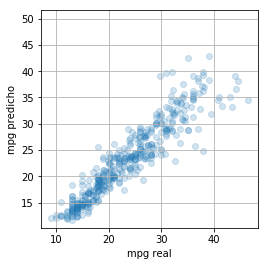

In [28]:
_ = plt.scatter(data['mpg'], mpg_pred, alpha=0.2)
_ = plt.axis('equal')
_ = plt.axis('square')
_ = plt.grid(True)
_ = plt.xlabel('mpg real')
_ = plt.ylabel('mpg predicho')

Como podemos ver, las predicciones del algoritmo son, en general, buenas. Sin embargo, para algunos vehículos se comete un error excesivo. Veamos que tienen en común los vehículos para los que se comete más error.

In [29]:
(results['mpg']-results['mpg_pred']).abs().sort_values(ascending=False)

car_name
oldsmobile cutlass ciera (diesel)    13.108769
mazda glc                            12.083650
audi 5000s (diesel)                  10.640527
vw dasher (diesel)                   10.114260
datsun 280-zx                         9.877427
vokswagen rabbit                      9.311712
mazda glc custom                      8.696840
vw rabbit                             8.098370
datsun 510 hatchback                  8.072158
volkswagen rabbit custom diesel       8.071671
honda civic (auto)                    7.900875
maxda rx3                             7.673516
vw rabbit c (diesel)                  7.589264
honda civic 1300                      7.509081
datsun b210 gx                        7.468045
oldsmobile cutlass ls                 7.297002
pontiac phoenix                       7.209245
honda civic 1500 gl                   6.435363
volvo diesel                          6.378226
datsun 210                            6.283650
triumph tr7 coupe                     6.266909
dats

Entre los peores figuran unos cuantos vehículos que, por su descripción, parecen ser diesel. Veamos donde se situarían estos vehículos en el gráfico anterior:

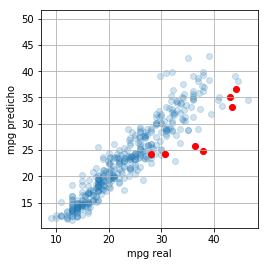

In [30]:
is_diesel = results.index.str.contains("diesel")


_ = plt.scatter(data['mpg'], mpg_pred, alpha=0.2)
_ = plt.scatter(data[is_diesel]['mpg'], mpg_pred[is_diesel], color='r')
_ = plt.axis('equal')
_ = plt.axis('square')
_ = plt.grid(True)
_ = plt.xlabel('mpg real')
_ = plt.ylabel('mpg predicho')



En esto casos, el modelo predice un consumo bastante inferior al real. De esto concluimos que sería interesante añadir un atributo que indicase el tipo de combustible.